In [1]:
import numpy as np
from time import clock
from conduction import ConductionND
from conduction.inversion import InvObservation, InvPrior
from conduction import InversionND
import matplotlib.pyplot as plt
%matplotlib inline

from petsc4py import PETSc
from mpi4py import MPI
comm = MPI.COMM_WORLD

In [2]:
def mapit(self, lithology, *args):
    """
    Requires a tuple of vectors corresponding to an inversion variable
    these are mapped to the mesh.

    tuple(vec1, vec2, vecN) --> tuple(field1, field2, fieldN)
    """

    nf = len(args)
    nl = len(self.lithology_index)

    # preallocate memory
    mesh_variables = np.zeros((nf, self.lithology.size))

    # unpack vector to field
    for i in range(0, nl):
        idx = lithology == self.lithology_index[i]
        for f in range(nf):
            mesh_variables[f,idx] = args[f][i]

    return list(mesh_variables)

def mapit_ad(self, lithology_ad, *args):
    """
    Map mesh variables back to the list
    """

    nf = len(args)
    nl = len(self.lithology_index)

    lith_variables = np.zeros((nf, self.lithology_index.size))

    for i in range(0, nl):
        idx = lithology_ad == self.lithology_index[i]
        for f in range(nf):
            lith_variables[f,i] += args[f][idx].sum()

    return list(lith_variables)

In [3]:
def forward_model(x, self, bc='Z'):
    """
    N-dimensional nonlinear model with flux lower BC
    Implements Hofmeister 1999 temperature-dependent
    conductivity law

    Arguments
    ---------
     x : [k_list, H_list, a_list, q0, lith_ratios]

    Returns
    -------
     cost : scalar

    """
    def hofmeister1999(k0, T, a=0.25, c=0.0):
        return k0*(298.0/T)**a + c*T**3

    nl = len(self.lithology_index)
    k_list, H_list, a_list = np.array_split(x[:3*nl], 3)
    q0 = x[3*nl]
    
    # map ratios to lithologies
    lith_ratios = x[3*nl+1:]
    lithology = self.lithology.copy()
    
    field_ratios = np.empty_like(lith_ratios)
    
    for i, index in enumerate(self.lithology_index):
        mask  = lithology == index
#         print("{} sum = {}".format(index, lith_ratios[mask].sum()))
        # the mean ratio across lithology
        golden_ratio = 1.0/mask.sum()
        field_ratios[mask] = golden_ratio
        
    # ratios < 1 = receive a node
    # radios > 1 = send a node
    ratios = lith_ratios / field_ratios
    ratio_idx = np.nonzero(ratios != 1)[0]
    
    # can't really use KDTree because node spacing is not uniform in each direction
    tree = self.ndinterp.tree
    d, nidx = tree.query(self.mesh.coords[ratio_idx], k=2*self.mesh.dim+1)
    
    transaction_log = []
    
    for i, idx in enumerate(nidx):
        # only look for nodes that from another lithology
        sortidx = np.argsort(ratios[idx])
        node = ratio_idx[i]
        node_neighbours = idx[sortidx]
        
        index = lithology[ratio_idx[i]]
        index_neighbours = lithology[idx][sortidx] # sorted neighbour indices by ratio
        neighbour_mask = index_neighbours != index
        
#         print i, idx, index, index_neighbours, neighbour_mask.sum()
        
        # pick a node based on ratio
        if neighbour_mask.any():
            index_nn = index_neighbours[neighbour_mask]
            node_nn = node_neighbours[neighbour_mask]
            if ratios[node] < 1:
                lithology[node_nn[-1]] = index # receive from highest node
                transaction_log.append([[index_nn[-1], index],[node_nn[-1], node]])
            elif ratios[node] > 1:
                lithology[node] = index_nn[0] # send to lowest node
                transaction_log.append([[index, index_nn[0]],[node, node_nn[0]]])
        
    self.transaction_log = transaction_log
    
    # map to mesh
    k0, H, a = mapit(self, lithology, k_list, H_list, a_list)
    self.lithology_new = lithology
    
    self.k0 = k0
    self.H = H
    self.a = a
    
    
    cost = 0.0
    cost += self.objective_function(k0, 3.5, 1.0)
    cost += self.objective_function(H,  2e-6, 1e-6)
    cost += self.objective_function(a,  0.5, 0.1)
    return cost

In [60]:
def tangent_linear(x, dx, self, bc='Z'):
    nl = len(self.lithology_index)
    k_list, H_list, a_list = np.array_split(x[:3*nl], 3)
    dk_list, dH_list, da_list = np.array_split(dx[:3*nl], 3)
    q0 = x[3*nl]
    dq0 = dx[3*nl]
    
    # map ratios to lithologies
    lith_ratios = x[3*nl+1:]
    dlith_ratios = dx[3*nl+1:]
    
    lithology = self.lithology.copy()
    dlithology = self.lithology.copy()
    
    field_ratios = np.empty_like(lith_ratios)
    
    for i, index in enumerate(self.lithology_index):
        mask  = lithology == index
        field_ratios[mask] = 1.0/mask.sum()

    
    # ratios < 1 = receive a node
    # radios > 1 = send a node
    ratios = lith_ratios / field_ratios
    ratio_idx = np.nonzero(ratios != 1)[0]
    
    dratiodlith = 1.0/field_ratios
    dratios = dratiodlith*dlith_ratios
    
    dratio_idx = np.nonzero(dratios != 0)[0]
    
#     dratios = dlith_ratios / field_ratios
#     dratio_idx = np.nonzero(dratios != 0)[0]
    
    # can't really use KDTree because node spacing is not uniform in each direction
    tree = self.ndinterp.tree
    d, nidx = tree.query(self.mesh.coords[ratio_idx], k=2*self.mesh.dim+1)
    
    transaction_log = []
    
    for i, idx in enumerate(nidx):
        # only look for nodes that from another lithology
        sortidx = np.argsort(ratios[idx])
        node = ratio_idx[i]
        node_neighbours = idx[sortidx]
        
        index = lithology[ratio_idx[i]]
        index_neighbours = lithology[idx][sortidx] # sorted neighbour indices by ratio
        neighbour_mask = index_neighbours != index
        
#         print i, idx, index, index_neighbours, neighbour_mask.sum()
        
        # pick a node based on ratio
        if neighbour_mask.any():
            index_nn = index_neighbours[neighbour_mask]
            node_nn = node_neighbours[neighbour_mask]
            if ratios[node] < 1:
                lithology[node_nn[-1]] = index # receive from highest node
                transaction_log.append([[index_nn[-1], index],[node_nn[-1], node]])
            elif ratios[node] > 1:
                lithology[node] = index_nn[0] # send to lowest node
                transaction_log.append([[index, index_nn[0]],[node, node_nn[0]]])

    self.transaction_log = transaction_log
    
#     dlithology = lithology.copy()
    
    d, dnidx = tree.query(self.mesh.coords[dratio_idx], k=2*self.mesh.dim+1)
    
    dtransaction_log = []
    
    for i, didx in enumerate(dnidx):
        sortidx = np.argsort(dratios[didx])
        node = dratio_idx[i]
        node_neighbours = didx[sortidx]
        
        index = dlithology[dratio_idx[i]]
        index_neighbours = dlithology[didx][sortidx] # sorted neighbour indices by ratio
        neighbour_mask = index_neighbours != index
        
#         print i, didx, index, index_neighbours, neighbour_mask.sum()
        
        if neighbour_mask.any():
            index_nn = index_neighbours[neighbour_mask]
            node_nn = node_neighbours[neighbour_mask]
            if dratios[node] < 0:
                dlithology[node_nn[-1]] = index # receive from highest node
                dtransaction_log.append([[index_nn[-1], index],[node_nn[-1], node]])
            elif dratios[node] > 0:
                dlithology[node] = index_nn[0] # send to lowest node
                dtransaction_log.append([[index, index_nn[0]],[node, node_nn[0]]])
                
    self.dtransaction_log = dtransaction_log
    
    # map to mesh
    k0, H, a = mapit(self, lithology, k_list, H_list, a_list)
    dk0, dH, da = mapit(self, lithology, dk_list, dH_list, da_list)
    
    
    
    
#     k0_, H_, a_= mapit(self, dlithology, k_list, H_list, a_list)
#     dk0 += k0_ - k0
#     dH  += H_  - H
#     da  += a_  - a
    
#     for (index_origin, index_destination), (node_origin, node_destination) in self.dtransaction_log:
#         dk0[node_destination] += k0[node_destination] - k0[node_origin]
#         dH[node_destination]  += H[node_destination] - H[node_origin]
#         da[node_destination]  += a[node_destination] - a[node_origin]
    
    self.lithology_new = lithology
    self.dlithology_new = dlithology
    
    cost = 0.0
    cost += self.objective_function(k0, 3.5, 1.0)
    cost += self.objective_function(H,  2e-6, 1e-6)
    cost += self.objective_function(a,  0.5, 0.1)
    
    self.dk0 = dk0
    self.dH = dH
    self.da = da
    
    dc = 0.0
    dcdk0 = self.objective_function_ad(k0, 3.5, 1.0)
    dcdH  = self.objective_function_ad(H, 2e-6, 1e-6)
    dcda  = self.objective_function_ad(a, 0.5, 0.1)
    dc += np.sum(dcdk0*dk0)
    dc += np.sum(dcdH*dH)
    dc += np.sum(dcda*da)

    return cost, dc

In [61]:
def adjoint_model(x, self, bc='Z'):

    nl = len(self.lithology_index)
    k_list, H_list, a_list = np.array_split(x[:3*nl], 3)
    dk_list, dH_list, da_list = np.array_split(dx[:3*nl], 3)
    q0 = x[3*nl]
    dq0 = dx[3*nl]
    
    # map ratios to lithologies
    lith_ratios = x[3*nl+1:]
    dlith_ratios = dx[3*nl+1:]
    
    lithology = self.lithology.copy()
    dlithology = self.lithology.copy()
    
    field_ratios = np.empty_like(lith_ratios)
    
    for i, index in enumerate(self.lithology_index):
        mask  = lithology == index
        field_ratios[mask] = 1.0/mask.sum()

    
    # ratios < 1 = receive a node
    # radios > 1 = send a node
    ratios = lith_ratios / field_ratios
    ratio_idx = np.nonzero(ratios != 1)[0]
    
    dratios = dlith_ratios / field_ratios
    dratio_idx = np.nonzero(dratios != 0)[0]
    
    # can't really use KDTree because node spacing is not uniform in each direction
    tree = self.ndinterp.tree
    d, nidx = tree.query(self.mesh.coords[ratio_idx], k=2*self.mesh.dim+1)
    
    transaction_log = []
    
    for i, idx in enumerate(nidx):
        # only look for nodes that from another lithology
        sortidx = np.argsort(ratios[idx])
        node = ratio_idx[i]
        node_neighbours = idx[sortidx]
        
        index = lithology[ratio_idx[i]]
        index_neighbours = lithology[idx][sortidx] # sorted neighbour indices by ratio
        neighbour_mask = index_neighbours != index
        
#         print i, idx, index, index_neighbours, neighbour_mask.sum()
        
        # pick a node based on ratio
        if neighbour_mask.any():
            index_nn = index_neighbours[neighbour_mask]
            node_nn = node_neighbours[neighbour_mask]
            if ratios[node] < 1:
                lithology[node_nn[-1]] = index # receive from highest node
                transaction_log.append([[index_nn[-1], index],[node_nn[-1], node]])
            elif ratios[node] > 1:
                lithology[node] = index_nn[0] # send to lowest node
                transaction_log.append([[index, index_nn[0]],[node, node_nn[0]]])
        
    self.transaction_log = transaction_log
    
    
    d, dnidx = tree.query(self.mesh.coords[dratio_idx], k=2*self.mesh.dim+1)
    
    dtransaction_log = []
    
    for i, didx in enumerate(dnidx):
        sortidx = np.argsort(dratios[didx])
        node = dratio_idx[i]
        node_neighbours = didx[sortidx]
        
        index = dlithology[dratio_idx[i]]
        index_neighbours = dlithology[didx][sortidx] # sorted neighbour indices by ratio
        neighbour_mask = index_neighbours != index
        
#         print i, didx, index, index_neighbours, neighbour_mask.sum()
        
        if neighbour_mask.any():
            index_nn = index_neighbours[neighbour_mask]
            node_nn = node_neighbours[neighbour_mask]
            if dratios[node] < 0:
                dlithology[node_nn[-1]] = index # receive from highest node
                dtransaction_log.append([[index_nn[-1], index],[node_nn[-1], node]])
            elif dratios[node] > 0:
                dlithology[node] = index_nn[0] # send to lowest node
                dtransaction_log.append([[index, index_nn[0]],[node, node_nn[0]]])
                
    self.dtransaction_log = dtransaction_log
    self.dlithology = dlithology
    
    # map to mesh
    k0, H, a = self.map(k_list, H_list, a_list)
    
    cost = 0.0
    cost += self.objective_function(k0, 3.5, 1.0)
    cost += self.objective_function(H,  2e-6, 1e-6)
    cost += self.objective_function(a,  0.5, 0.1)
    
    
    # ADJOINT MODEL
    
    dk0 = self.objective_function_ad(k0, 3.5, 1.0)
    dH  = self.objective_function_ad(H, 2e-6, 1e-6)
    da  = self.objective_function_ad(a, 0.5, 0.1)
    
    dk_list, dH_list, da_list = self.map_ad(dk0, dH, da)
    
    dlithology = np.zeros_like(lithology)
    dratios = np.zeros_like(ratios)
    dlith_ratios = np.zeros_like(lith_ratios)
    
#     k0a, Ha, aa = 
    
#     for i, (index_origin, index_destination, node_origin, node_destination) in enumerate(self.transaction_log):
#         dlithology[node_origin] = index_origin
#         dratios[node_origin] = 
    
    delta_lithology

    return cost, gradient

In [62]:
minX, maxX = 0.0, 1000.0
minY, maxY = -1000.0, 0.0
nx, ny = 10, 10
n = nx*ny

mesh = ConductionND((minX, minY), (maxX, maxY), (nx,ny))

# BCs
mesh.boundary_condition('maxY', 298.0, flux=False)
mesh.boundary_condition('minY', 1e3, flux=True)


# In[3]: Global lithology

lithology = np.zeros((ny,nx), dtype='int32')
lithology[3:7,:] = 1
lithology[7:,:]  = 2

lithology_ratios = np.empty_like(lithology, dtype=np.float)

ratio0 = 1.0/(lithology == 0).sum()
ratio1 = 1.0/(lithology == 1).sum()
ratio2 = 1.0/(lithology == 2).sum()

lithology_ratios.fill(ratio0)
lithology_ratios[3:7,:] = ratio1
lithology_ratios[7:, :] = ratio2


# Need to slice this bad boy up: Local lithology

(minI, maxI), (minJ, maxJ) = mesh.dm.getGhostRanges()
lithology = lithology[minJ:maxJ, minI:maxI]

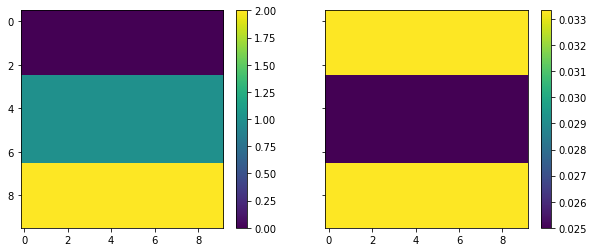

In [63]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,4))

im1 = ax1.imshow(lithology.reshape(ny,nx))
fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(lithology_ratios.reshape(ny,nx))
fig.colorbar(im2, ax=ax2)

**Priors**

In [64]:
inv = InversionND(lithology.flatten(), mesh)

k = np.array([3.5, 2.0, 3.2])
H = np.array([0.5e-6, 1e-6, 2e-6])
a = np.array([0.3, 0.3, 0.3])
q0 = 35e-3
sigma_q0 = 5e-3


# Inversion variables
x = np.hstack([k, H, a, [q0], lithology_ratios.flatten()])
dx = x*0.01
dx[:10] = 0.0

In [65]:
forward_model(x, inv, 'Y')

600.2

In [66]:
inv.lithology = lithology.flatten()
forward_model(x+dx, inv, 'Y')

578.6

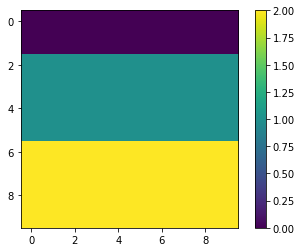

In [67]:
plt.imshow(inv.lithology_new.reshape(ny,nx))
plt.colorbar()

# inv.transaction_log

In [68]:
inv.lithology = lithology.flatten()
tangent_linear(x, dx, inv, 'Y')

(578.6, 0.0)

In [69]:
fm0 = forward_model(x, inv, 'Y')
fm1 = forward_model(x+dx, inv, 'Y')
tl = tangent_linear(x, dx, inv, 'Y')

print("finite difference {}".format(fm1 - fm0))
print("tangent linear {}".format(tl[1]))

finite difference -21.6
tangent linear 0.0


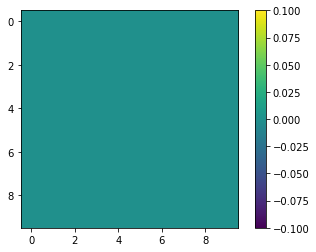

In [70]:
plt.imshow(inv.dk0.reshape(ny,nx))
plt.colorbar()

In [37]:
inv.dtransaction_log

[[[0, 1], [20, 30]],
 [[0, 1], [21, 20]],
 [[0, 1], [22, 21]],
 [[0, 1], [23, 22]],
 [[0, 1], [24, 23]],
 [[0, 1], [25, 24]],
 [[0, 1], [26, 36]],
 [[0, 1], [27, 26]],
 [[0, 1], [28, 27]],
 [[0, 1], [29, 28]],
 [[1, 2], [60, 70]],
 [[1, 2], [61, 71]],
 [[1, 2], [62, 72]],
 [[1, 2], [63, 73]],
 [[1, 2], [64, 74]],
 [[1, 2], [65, 75]],
 [[1, 2], [66, 76]],
 [[1, 2], [67, 77]],
 [[1, 2], [68, 78]],
 [[1, 2], [69, 79]]]

In [210]:
# Priors
k_prior = k*1.1
H_prior = H*1.1
a_prior = a*1.1
sigma_k = k*0.1
sigma_H = H*0.1
sigma_a = a*0.1

kp = InvPrior(k_prior, sigma_k)
Hp = InvPrior(H_prior, sigma_H)
ap = InvPrior(a_prior, sigma_a)
q0p = InvPrior(q0, sigma_q0)